In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [349]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['week'] = df[date_col].dt.week
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

### PJM Historical Load Forecasts
From https://dataminer2.pjm.com/feed/load_frcstd_hist

In [429]:
# PJM Load Forecasts
pjm_df = pd.concat(map(pd.read_csv, ['load_forecasts/pjm/2016.csv', 'load_forecasts/pjm/2017.csv','load_forecasts/pjm/2018.csv']))
pjm_df = pjm_df.drop(['evaluated_at_utc', 'evaluated_at_ept', 'forecast_hour_beginning_ept'], axis = 1)
pjm_df.columns = ['Date', 'area', 'PJM']

In [430]:
# RTO columns represent the load forecast for all of PJM
pjm_df = pjm_df.loc[pjm_df['area'] == 'RTO']

In [431]:
# There are multiple forecasts provided per hour so start by averaging them  
pjm_df = pjm_df.groupby( ['Date'] ).mean().reset_index()

In [432]:
pjm_df['Date'] = pd.to_datetime(pjm_df['Date'])
pjm_df = extract_date(pjm_df, 'Date') 

pjm_df = pjm_df.sort_values(by=['year', 'month', 'day', 'hour'])
pjm_df = pjm_df.set_index(['year', 'month', 'day', 'hour'])

pjm_df = pjm_df.drop(['Date'], axis = 1)

### Get Predictions: Hydro, Nuclear, Solar, and Wind

In [433]:
# Load predictions into a DF
hydro_pred = pd.read_csv('Predictions/hydro_pred.csv', index_col = 0)
nuclear = pd.read_csv('Predictions/nuclear_weekly_average.csv', index_col = 0)
solar_pred = pd.read_csv('Predictions/solar_pred.csv', index_col = 0)
wind_pred = pd.read_csv('Predictions/wind_pred.csv', index_col = 0)

In [434]:
# Ensure column names are the same, set date time information as index 
hydro_pred.columns = ['year', 'month', 'day', 'hour', 'hydro']
solar_pred.columns = ['year', 'month', 'day', 'hour', 'solar']
wind_pred.columns = ['year', 'month', 'day', 'hour', 'wind']

hydro_pred = hydro_pred.set_index(['year', 'month', 'day', 'hour'])
solar_pred = solar_pred.set_index(['year', 'month', 'day', 'hour'])
wind_pred = wind_pred.set_index(['year', 'month', 'day', 'hour'])

In [435]:
# Combine solar, wind, hydro predictions 
combined = hydro_pred.merge(solar_pred, how='inner', left_index=True, right_index=True)
combined = combined.merge(wind_pred, how='inner', left_index=True, right_index=True)

In [436]:
# Add a week column to merge with nuclear values 
combined = combined.reset_index()
combined['datetime'] = pd.to_datetime(combined['year'] * 1000 + combined['day'], format='%Y%j')

combined['week'] = combined['datetime'].dt.week

In [437]:
nuclear.columns = ['year', 'week', 'nuclear']

In [438]:
combined = combined.merge(nuclear, how='inner', on=['year', 'week'])

In [439]:
combined = combined.drop(['datetime', 'week'], axis = 1)
combined = combined.sort_values(by=['year', 'month', 'day', 'hour'])
combined =combined.set_index(['year', 'month', 'day', 'hour'])

In [440]:
combined

hydro       solar        wind       nuclear
year month day hour                                                  
2017 8     221 0     1533.07920    0.288575   427.97510  33203.947024
               1     1022.36163   -1.158340   393.80902  33203.947024
               2      501.96463   -1.458225   548.25256  33203.947024
               3      469.56433   -1.203336   545.13824  33203.947024
               4      486.13455   -0.896589   605.94700  33203.947024
...                         ...         ...         ...           ...
     12    364 19    1603.29910  257.476440  3219.41750  35374.167456
               20    1307.56980  217.048030  3037.98410  35374.167456
               21    1466.46770  103.606540  2949.86600  35374.167456
               22    4063.69070   39.545753  2923.30520  35374.167456
               23    3897.44240   -5.528568  3326.43650  35374.167456

[3456 rows x 4 columns]

### Get Fossil Forecasts
Fossil Forecast = Load Forecast - Hydro - Nuclear - Wind - Solar

In [441]:
fossil_gen = combined.merge(pjm_df, how='inner', left_index=True, right_index=True)

In [443]:
# Add net import with PJM 
fossil_gen['fossil gen'] = fossil_gen['PJM'] - fossil_gen['hydro'] - fossil_gen['solar'] - fossil_gen['wind'] - fossil_gen['nuclear'] 


In [444]:
fossil_gen

hydro       solar        wind       nuclear  \
year month day hour                                                     
2017 8     221 0     1533.07920    0.288575   427.97510  33203.947024   
               1     1022.36163   -1.158340   393.80902  33203.947024   
               2      501.96463   -1.458225   548.25256  33203.947024   
               3      469.56433   -1.203336   545.13824  33203.947024   
               4      486.13455   -0.896589   605.94700  33203.947024   
...                         ...         ...         ...           ...   
     12    364 19    1603.29910  257.476440  3219.41750  35374.167456   
               20    1307.56980  217.048030  3037.98410  35374.167456   
               21    1466.46770  103.606540  2949.86600  35374.167456   
               22    4063.69070   39.545753  2923.30520  35374.167456   
               23    3897.44240   -5.528568  3326.43650  35374.167456   

                          PJM  week    fossil gen  
year month day hour                                
2017 8     221 0     101594.1    32  66428.810101  
               1      98697.6    32  64078.640666  
               2      91817.4    32  57564.694011  
               3      83951.2    32  49733.753742  
               4      77740.0    32  43444.868015  
...                       ...   ...           ...  
     12    364 19    102898.7    52  62444.339504  
               20    102956.9    52  63020.130614  
               21    105561.9    52  65667.792304  
               22    111177.3    52  68776.590891  
               23    113618.1    52  71025.582213  

[3456 rows x 7 columns]

### Compare to Fossil Generation (Coal, Gas, Multiple Fuels, Oil)

In [465]:
actual_gen = pd.read_csv('actual_gen.csv')

In [466]:
fossil_fuel_type = ['Coal', 'Gas', 'Multiple Fuels', 'Oil']
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(fossil_fuel_type)]

In [467]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])


In [468]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.sort_values(by=['year', 'month', 'day', 'hour'])


In [469]:
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [472]:
actual_gen = actual_gen.drop('week', axis = 1)

In [473]:
merged = actual_gen.merge(fossil_gen, how='inner', left_index=True, right_index=True)


In [475]:
actual = merged[['mw']]
predicted = merged[['fossil gen']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(300)
predicted_100 = predicted.head(300)

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [476]:
print("RMSE: " + str(((predicted['fossil gen'] - actual.mw) ** 2).mean() ** .5))

RMSE: 4102.26489465148


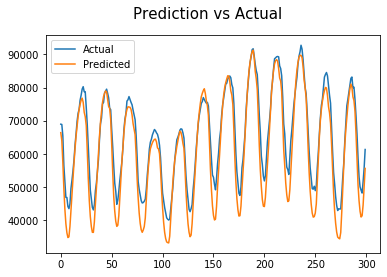

In [477]:
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['fossil gen'], label='Predicted')
plt.legend()

### Compare Weekly, Monthly, and Hourly Average

In [478]:
predicted = predicted.reset_index()
actual = actual.reset_index()

In [479]:
predicted.to_csv('Predictions/fossil_gen.csv')

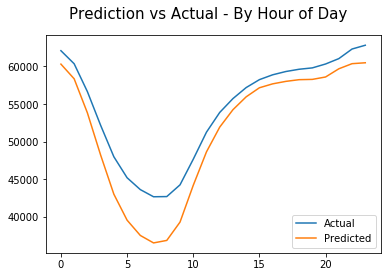

In [480]:
# Find hourly average 
predicted_hourly = predicted.groupby( ['hour'] ).mean().reset_index()
actual_hourly = actual.groupby(['hour']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Hour of Day', fontsize=15)
plt.plot(actual_hourly['mw'], label='Actual')
plt.plot(predicted_hourly['fossil gen'], label='Predicted')
plt.legend()

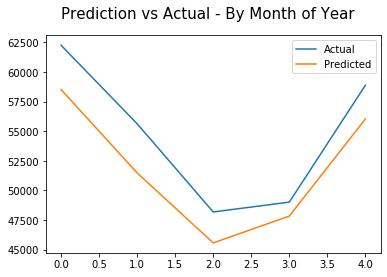

In [481]:
# Find monthly average 
predicted_hourly = predicted.groupby( ['month'] ).mean().reset_index()
actual_hourly = actual.groupby(['month']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Month of Year', fontsize=15)
plt.plot(actual_hourly['mw'], label='Actual')
plt.plot(predicted_hourly['fossil gen'], label='Predicted')
plt.legend()

In [482]:
predicted['datetime'] = pd.to_datetime(predicted['year'] * 1000 + predicted['day'], format='%Y%j')
predicted['week'] = predicted['datetime'].dt.week

In [483]:
actual['datetime'] = pd.to_datetime(actual['year'] * 1000 + actual['day'], format='%Y%j')
actual['week'] = actual['datetime'].dt.week

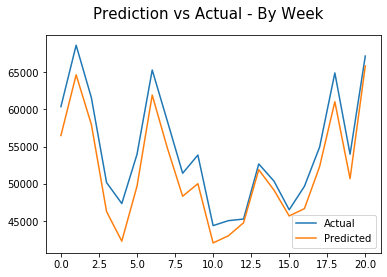

In [484]:
# Find weekly average 
predicted_hourly = predicted.groupby( ['week'] ).mean().reset_index()
actual_hourly = actual.groupby(['week']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Week', fontsize=15)
plt.plot(actual_hourly['mw'], label='Actual')
plt.plot(predicted_hourly['fossil gen'], label='Predicted')
plt.legend()